In [170]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor

import math
import random
from datetime import datetime

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [171]:
TRAIN_DATASET_PATH='./train.csv'
TEST_DATASET_PATH='./test.csv'
SUBMIT_DATESET_PATH='./sample_submission.csv'

In [172]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))

    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')

    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [173]:
class DataPreprocessing:
    def __init__(self):
        self.medians = None
        self.kitchen_square_quantile = None

    def fit(self, x: pd.DataFrame) -> None:
        self.medians = x.median()
        self.kitchen_square_quantile = x['KitchenSquare'].quantile(0.975)

    def transform(self, x: pd.DataFrame) -> pd.DataFrame:
        x = x.copy()

        self.__transform_rooms(x)
        self.__transform_floors(x)
        self.__transform_square(x)
        self.__transform_kitchen_square(x)
        self.__transform_squares(x)
        self.__transform_years(x)
        self.__transform_healthcare(x)

        x.fillna(self.medians, inplace=True)

        return x

    def __transform_rooms(self, x: pd.DataFrame) -> None:
        x['RoomsOutlier'] = 0
        x.loc[(x['Rooms'] < 1) | (x['Rooms'] > 6), 'RoomsOutlier'] = 1

        x.loc[x['Rooms'] < 1, 'Rooms'] = 1
        x.loc[x['Rooms'] > 5, 'Rooms'] = self.medians['Rooms']

    def __transform_square(self, x: pd.DataFrame) -> None:
        x['SquareOutlier'] = 0
        condition = (x['Square'] < 15) | (x['Square'] > 130)
        x.loc[condition, 'SquareOutlier'] = 1
        x.loc[condition, 'Square'] = self.medians['Square']

    def __transform_kitchen_square(self, x: pd.DataFrame) -> None:
        condition = (x['KitchenSquare'].isna()) | (x['KitchenSquare'] > self.medians['KitchenSquare'])

        x.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
        x.loc[x['KitchenSquare'] < 3, 'KitchenSquare'] = 3

    def __transform_squares(self, x: pd.DataFrame) -> None:
        def _fix_squares(row: pd.DataFrame):
            if row['LifeSquare'] > row['Square']:
                row['LifeSquare'] = row['Square'] * 0.6

            return row

        x.loc[:, 'LifeSquare'] = x.apply(_fix_squares, axis=1)['LifeSquare']

    def __transform_floors(self, x: pd.DataFrame) -> None:
        x['HouseFloorOutlier'] = 0
        x.loc[x['HouseFloor'] < 1, 'HouseFloorOutlier'] = 1
        x.loc[x['HouseFloor'] < 1, 'HouseFloor'] = self.medians['HouseFloor']

        floor_outlier_indexes = x.loc[x['Floor'] > x['HouseFloor']].index
        x.loc[floor_outlier_indexes, 'Floor'] = x.loc[floor_outlier_indexes, 'HouseFloor'].apply(lambda x: random.randint(1, x))

    def __transform_years(self, x: pd.DataFrame) -> None:
        now_year = datetime.now().year
        x.loc[x['HouseYear'] > (now_year - 1), 'HouseYear'] = now_year - 1

    def __transform_healthcare(self, x: pd.DataFrame) -> None:
        def _fix_healthcare(row):
            healthcare = row['Healthcare_1']

            if math.isnan(healthcare):
                healthcare_series = x[x['DistrictId'] == row['DistrictId']]['Healthcare_1']
                healthcare_modes = healthcare_series.mode()
                row['Healthcare_1'] = healthcare_modes[0] if len(healthcare_modes) else 0

            return row

        x.loc[:, 'Healthcare_1'] = x.apply(_fix_healthcare, axis=1)['Healthcare_1']


In [174]:
class FeatureGenerator:
    def __init__(self):
        self.district_sizes = None
        self.aggregated_prices = {'DistrictId': None, 'FloorAndYear': None}
        self.minimals = {'Floor': None, 'HouseYear': None}
        self.maximals = {'Floor': None, 'HouseYear': None}
        self.binary_to_numbers = {'A': 1, 'B': 0}

    def fit(self, x: pd.DataFrame, y: pd.Series = None) -> None:
        x = x.copy()

        self.district_sizes = x['DistrictId'].value_counts().reset_index()\
            .rename(columns={'index': 'DistrictId', 'DistrictId': 'DistrictSize'})

        self.minimals['Floor'] = x['Floor'].min()
        self.minimals['HouseYear'] = x['HouseYear'].min()

        self.maximals['Floor'] = x['Floor'].max()
        self.maximals['HouseYear'] = x['HouseYear'].max()

        x = self.__floor_to_cat(x)
        x = self.__house_year_to_cat(x)

        self.__fit_target_encoding(x, y)

    def transform(self, x: pd.DataFrame) -> pd.DataFrame:
        x = x.copy()

        for key in ['Ecology_2', 'Ecology_3', 'Shops_2']:
            x[key] = x[key].map(self.binary_to_numbers)

        x = x.merge(self.district_sizes, on=['DistrictId'], how='left')

        x['DistrictIdNew'] = 0
        x.loc[x['DistrictSize'].isna(), 'DistrictIdNew'] = 1

        x['DistrictSize'].fillna(5, inplace=True)

        x['DistrictLarge'] = (x['DistrictSize'] > 100).astype(int)

        x = self.__house_year_to_cat(x)
        x = self.__floor_to_cat(x)

        if self.aggregated_prices['DistrictId'] is not None:
            x = x.merge(self.aggregated_prices['DistrictId'], on=['DistrictId', 'Rooms'], how='left')
            x['MedianPriceByDistrict'].fillna(self.aggregated_prices['DistrictId']['MedianPriceByDistrict'].median(), inplace=True)

        if self.aggregated_prices['FloorAndYear'] is not None:
            x = x.merge(self.aggregated_prices['FloorAndYear'], on=['FloorCat', 'HouseYearCat'], how='left')
            x['MedianPriceByFloorAndYear'].fillna(self.aggregated_prices['FloorAndYear']['MedianPriceByFloorAndYear'].median(), inplace=True)

        return x

    def __fit_target_encoding(self, x: pd.DataFrame, y: pd.Series = None) -> None:
        data = x.copy()

        if y is not None:
            data['Price'] = y

            self.aggregated_prices['DistrictId'] = data.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'median'})\
                .rename(columns={'Price': 'MedianPriceByDistrict'})

            self.aggregated_prices['FloorAndYear'] = data.groupby(['HouseYearCat', 'FloorCat'], as_index=False).agg({'Price': 'median'})\
                .rename(columns={'Price': 'MedianPriceByFloorAndYear'})

    def __floor_to_cat(self, x: pd.DataFrame) -> pd.DataFrame:
        bins = [self.minimals['Floor'], 3, 5, 9, 15, self.maximals['Floor']]
        x['FloorCat'] = pd.cut(x['Floor'], bins=bins, labels=False)
        x['FloorCat'].fillna(-1, inplace=True)

        return x

    def __house_year_to_cat(self, x: pd.DataFrame) -> pd.DataFrame:
        bins = [self.minimals['HouseYear'], 1950, 1960, 1970, 1980, 1990, 2000, 2010, self.maximals['HouseYear']]
        x['HouseYearCat'] = pd.cut(x['HouseYear'], bins=bins, labels=False)
        x['HouseYearCat'].fillna(-1, inplace=True)

        return x


In [175]:
feature_names = [
    'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
    'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
    'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2'
]

new_feature_names = [
    'RoomsOutlier', 'HouseFloorOutlier', 'SquareOutlier',
    'DistrictSize', 'DistrictIdNew', 'DistrictLarge',
    'HouseYearCat', 'FloorCat',
    'MedianPriceByDistrict', 'MedianPriceByFloorAndYear'
]

target_name = 'Price'

In [176]:
df = pd.read_csv(TRAIN_DATASET_PATH)

preprocessor = DataPreprocessing()
preprocessor.fit(df)
df = preprocessor.transform(df)

feature_generator = FeatureGenerator()
feature_generator.fit(df)
df = feature_generator.transform(df)

df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,RoomsOutlier,HouseFloorOutlier,SquareOutlier,DistrictSize,DistrictIdNew,DistrictLarge,HouseYearCat,FloorCat
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.887600,55.717322,33.915023,4.920400,7.405900,12.95910,1984.872600,0.118858,...,0.082500,214138.857399,0.00110,0.026900,0.006500,242.306600,0.0,0.506900,3.902700,1.589300
std,4859.01902,43.587592,0.811438,17.601980,13.397634,1.353457,5.031429,6.44346,18.416734,0.119025,...,0.275139,92872.293865,0.03315,0.161799,0.080364,268.992652,0.0,0.499977,1.829199,1.415566
min,0.00000,0.000000,1.000000,16.117154,0.370619,3.000000,1.000000,1.00000,1910.000000,0.000000,...,0.000000,59174.778028,0.00000,0.000000,0.000000,1.000000,0.0,0.000000,-1.000000,-1.000000
25%,4169.50000,20.000000,1.000000,41.800063,24.565550,3.000000,3.000000,9.00000,1974.000000,0.017647,...,0.000000,153872.633942,0.00000,0.000000,0.000000,55.000000,0.0,0.000000,3.000000,0.000000
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,6.000000,13.00000,1977.000000,0.075424,...,0.000000,192269.644879,0.00000,0.000000,0.000000,104.000000,0.0,1.000000,3.000000,2.000000
75%,12592.50000,75.000000,2.000000,65.684193,38.948052,6.000000,11.000000,17.00000,2001.000000,0.195781,...,0.000000,249135.462171,0.00000,0.000000,0.000000,511.000000,0.0,1.000000,6.000000,3.000000
max,16798.00000,209.000000,5.000000,129.998756,125.306808,6.000000,42.000000,117.00000,2021.000000,0.521867,...,1.000000,633233.466570,1.00000,1.000000,1.000000,851.000000,0.0,1.000000,7.000000,4.000000


<AxesSubplot:>

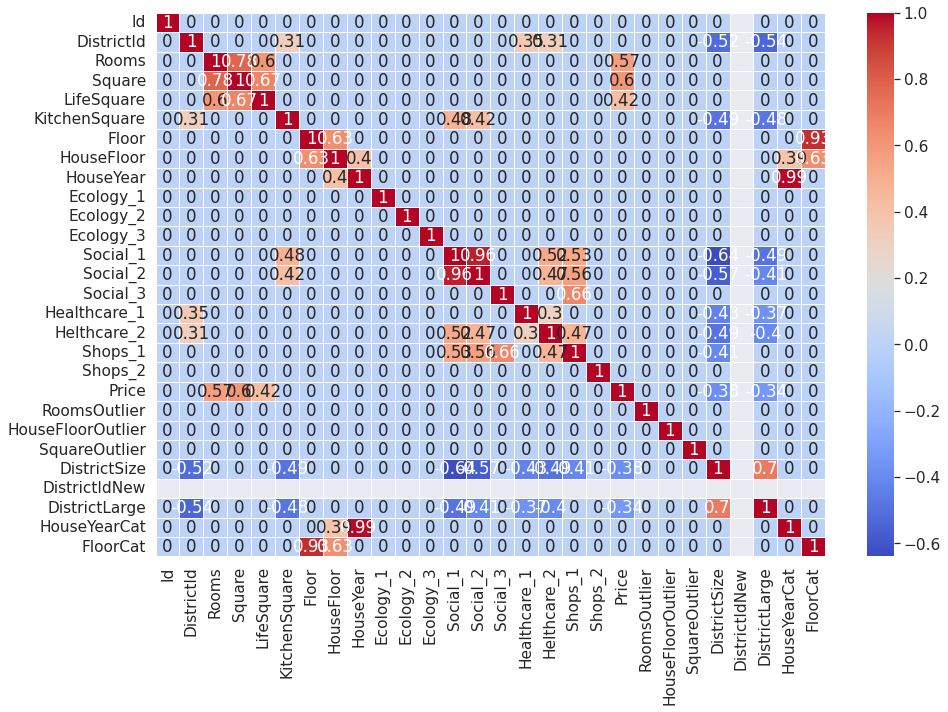

In [177]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=0.5, cmap='coolwarm')

In [178]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [179]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

preprocessor = DataPreprocessing()
feature_generator = FeatureGenerator()

preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

feature_generator.fit(X_train, y_train)

X_train = feature_generator.transform(X_train)
X_valid = feature_generator.transform(X_valid)
test_df = feature_generator.transform(test_df)

X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]


In [180]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [181]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Train R2:	0.966
Test R2:	0.687


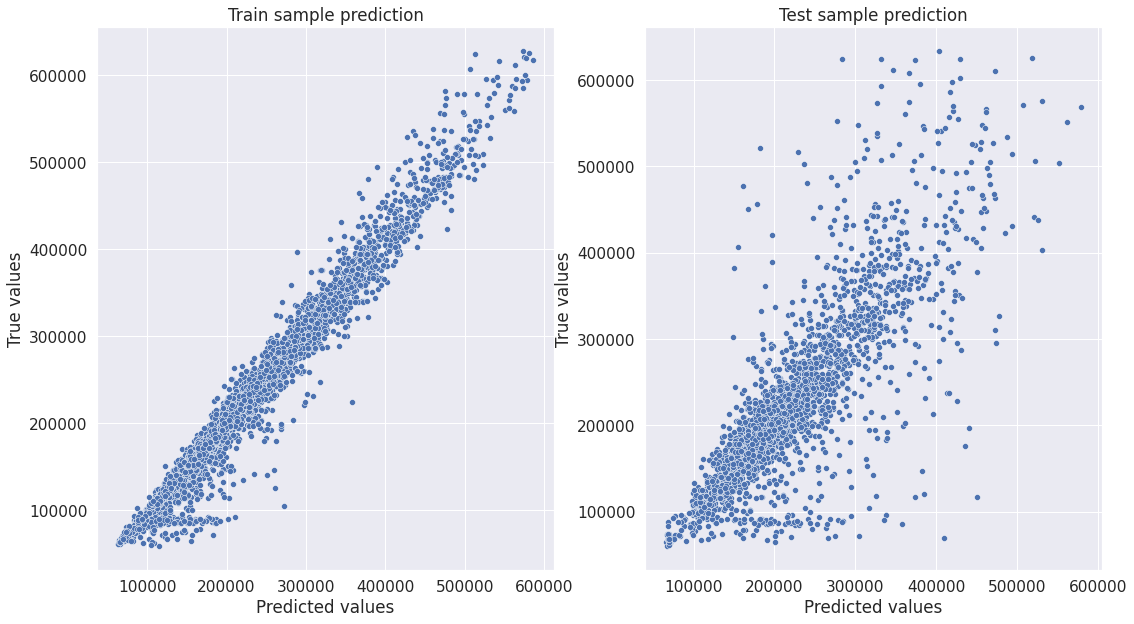

In [182]:
y_train_preds = model.predict(X_train)
y_test_preds = model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [183]:
submit = pd.read_csv(SUBMIT_DATESET_PATH)
predictions = model.predict(test_df)
submit['Price'] = predictions

submit.to_csv('./rf_submit.csv', index=False)

submit


,Id,Price
0,4567,167642.657814
1,5925,113114.958630
2,960,138940.507485
3,3848,157849.933941
4,746,176383.611092
...,...,...
4995,10379,188370.198587
4996,16138,330031.166855
4997,3912,143992.227162
4998,5722,177343.157814
